In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/sentiment"

In [ ]:
%cd "/content/gdrive/My Drive/sentiment" 

/content/gdrive/My Drive/sentiment


In [ ]:
pip install transformers

     |████████████████████████████████| 4.2 MB 4.7 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 84 kB 2.4 MB/s 
     |████████████████████████████████| 6.6 MB 31.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install fast_ml==3.68

     |████████████████████████████████| 42 kB 447 kB/s 


In [ ]:
import pandas as pd
import numpy as np
from transformers import Trainer, TrainingArguments, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
from torch.nn.functional import softmax

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f'Device Availble: {DEVICE}')

Device Availble: cpu


In [ ]:
class DataLoader(torch.utils.data.Dataset):
    def __init__(self, sentences=None, labels=None):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        
        if bool(sentences):
            self.encodings = self.tokenizer(self.sentences,
                                            truncation = True,
                                            padding = True)
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        if self.labels == None:
            item['labels'] = None
        else:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.sentences)
    
    
    def encode(self, x):
        return self.tokenizer(x, return_tensors = 'pt').to(DEVICE)

In [ ]:
class SentimentModel():
    
    def __init__(self, model_path):
        
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path).to(DEVICE)
        args =  TrainingArguments(output_dir='/kaggle/working/results', per_device_eval_batch_size=64)
        self.batch_model = Trainer(model = self.model, args= args)
        self.single_dataloader = DataLoader()
        
    def batch_predict_proba(self, x):
        
        predictions = self.batch_model.predict(DataLoader(x))
        logits = torch.from_numpy(predictions.predictions)
        
        if DEVICE == 'cpu':
            proba = torch.nn.functional.softmax(logits, dim = 1).detach().numpy()
        else:
            proba = torch.nn.functional.softmax(logits, dim = 1).to('cpu').detach().numpy()
        return proba
        
        
    def predict_proba(self, x):
        
        x = self.single_dataloader.encode(x).to(DEVICE)
        predictions = self.model(**x)
        logits = predictions.logits
        
        if DEVICE == 'cpu':
            proba = torch.nn.functional.softmax(logits, dim = 1).detach().numpy()
        else:
            proba = torch.nn.functional.softmax(logits, dim = 1).to('cpu').detach().numpy()
        return proba

In [ ]:
df = pd.read_csv('./AMAZON_FASHION_5.csv')
# df.drop(columns = ['Unnamed: 0'], inplace = True)
df_reviews = df.loc[:, ['reviewText', 'overall']].dropna()
df_reviews['Rating'] = df_reviews['overall'].apply(lambda x: f'{x} Stars' if x != 1 else f'{x} Star')
df_reviews.head()

,reviewText,overall,Rating
0,Great product and price!,5,5 Stars
1,Great product and price!,5,5 Stars
2,Great product and price!,5,5 Stars
3,Great product and price!,5,5 Stars
4,Great product and price!,5,5 Stars


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df.corr()

,overall,verified,unixReviewTime,vote
overall,1.000000,-0.059741,0.044296,-0.195851
verified,-0.059741,1.000000,0.093568,0.088629
unixReviewTime,0.044296,0.093568,1.000000,-0.615110
vote,-0.195851,0.088629,-0.615110,1.000000


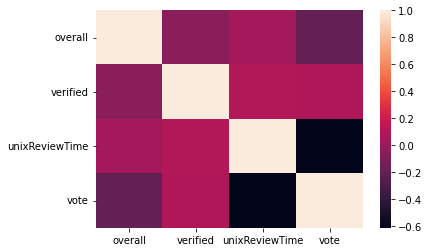

In [ ]:
sns.heatmap(df.corr());

In [ ]:
batch_sentences = df_reviews.sample(n = 1000, random_state = 1)['reviewText'].to_list()
single_sentence = df_reviews.sample(n = 1, random_state = 1)['reviewText'].to_list()[0]

In [ ]:
sentiment_model = SentimentModel('./sentiment_model')

https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx31mcqor


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/distilbert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpmqre37lz


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.0

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4ltuoqmd


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading

In [ ]:
single_sentence_probas = sentiment_model.predict_proba(single_sentence)
id2label = sentiment_model.model.config.id2label
predicted_class_label = id2label[np.argmax(single_sentence_probas)]

print (predicted_class_label)

3 Stars


In [ ]:
batch_sentence_probas = sentiment_model.batch_predict_proba(batch_sentences)
predicted_class_labels = [id2label[i] for i in np.argmax(batch_sentence_probas, axis = -1)]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

In [ ]:
for sentence in batch_sentences:
    single_sentence_probas = sentiment_model.predict_proba(sentence)

batch_sentence_probas = sentiment_model.batch_predict_proba(batch_sentences)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10